## Introduction to Qiskit

### Ritajit Majumdar
Research Scientist @ IBM Quantum

Let us select a Bell state as our problem of interest

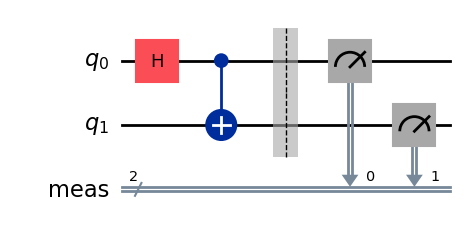

In [14]:
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

qc.draw('mpl')

### Obtaining the probability distribution: Introduction to Sampler

Qiskit Runtime offers two primitives - Sampler and Estimator. The former is used to obtain the probability distribution of a circuit. In this section, we shall see the usage of Sampler.

You can install the latest version of Qiskit Runtime by *pip install qiskit-ibm-runtime*. Note that with Qiskit 1.0, you may need to separately install qiskit-aer by *pip install qiskit-aer*.

In [15]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2

backend = AerSimulator()
sampler = SamplerV2(backend=backend)

# You can set the number of shots you want for your experiment
sampler.options.default_shots = 4096

Using sampler allows you to also use dynamical decoupling to your problem without manually working on it. For example,

*sampler.options.dynamical_decoupling.enable = True*

*sampler.options.dynamical_decoupling.sequence_type = 'xpxm'*

In [16]:
job = sampler.run([qc])
job.job_id()

'ce914f6e-fd87-4d9f-8c37-897d39f5bc04'

Note that *job_id* is not useful for local simulation. But when you use real quantum device, you will most likely encounter a queue. So it is useful to keep the *job_id* handy. This way you can turn off / send to sleep mode your laptop while the program waits on queue, and gets executed. Once the result is ready, you can retrieve the job using this *job_id* and obtain the results.

Note that both the primitives allow you to send multiple circuits together for execution. You can do that by job = sampler.run([qc1,qc2,...]). So your result is an array with the i-th entry giving you the outcome of the i-th circuit.

Since for this example, there is only one circuit, we take the 0-th entry of the result

In [17]:
result = job.result()[0]
counts = result.data.meas.get_counts()
counts

{'00': 2077, '11': 2019}

You can also plot the count as a histogram for better visualization. Note that you need to install *qiskit-visualization* for this

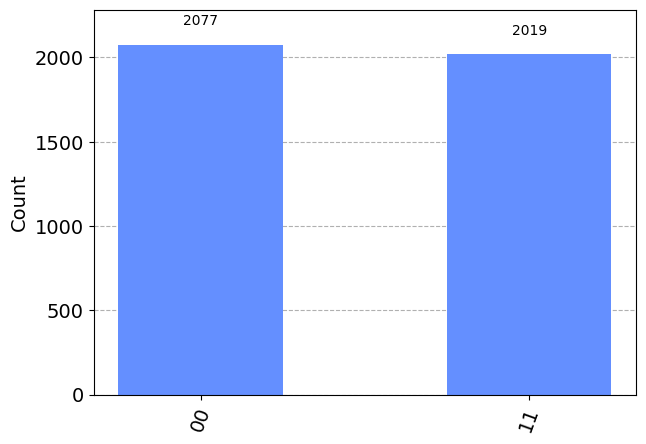

In [18]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

### Calculating expectation value from probability distribution

#### For observables diagonal in Z basis

Let us assume that you want to calculate the expectation value of $\langle ZZ \rangle$ for the Bell state. You can do that by using the *sampled_expectation_value* function, and the *SparsePauliOp* class for observables.

In [19]:
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp

In [20]:
observable_zz = SparsePauliOp('ZZ')
observable_zz

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])

In [21]:
expval_zz = sampled_expectation_value(counts, observable_zz)
print(f'Expectation value of <ZZ> is {expval_zz}')

Expectation value of <ZZ> is 1.0


You can similarly calculate the expcation value of observables like, say, $\langle ZI \rangle$.

In [22]:
observable_zi = SparsePauliOp('ZI')
expval_zi = sampled_expectation_value(counts, observable_zi)
print(f'Expectation value of <ZI> is {expval_zi}')

Expectation value of <ZI> is 0.01416015625


Note that we know the ideal expecation value of $\langle ZI \rangle$ is 0. But that is in the range of infinite shots. Here we have $(2040-2056)/4096 = -0.0039$. The more you increase the number of shots, the closer will this value be to 0.

#### For observables which are not diagonal in Z basis

##### X type observables

If the observable is not diagonal in $Z$ basis, then it is necessary to change the measurement basis. But quantum hardware can measure only in $Z$ basis. So we apply a unitary *before measurement* in order to set the correct rotation. For measurement in $X$ basis, we need to add a Hadamard gate before measurement since HZH = X.

Let us measure the expectation value of $\langle XX \rangle$.

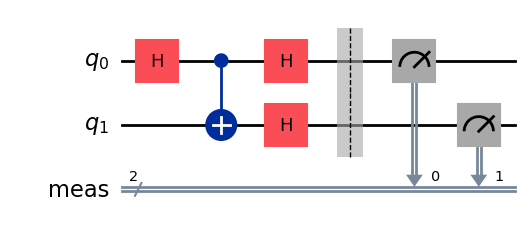

In [23]:
qc_x = qc.copy()
qc_x.remove_final_measurements()
qc_x.h([0,1]) # these hadamard gates ensure that now measurement is in X basis
qc_x.measure_all()

qc_x.draw('mpl')

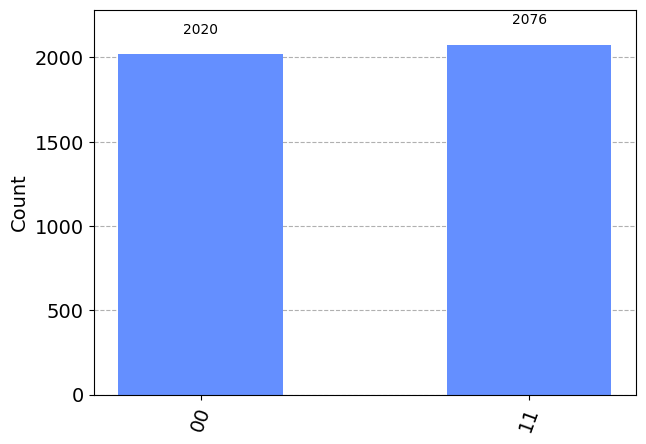

In [24]:
counts_x = sampler.run([qc_x]).result()[0].data.meas.get_counts()
plot_histogram(counts_x)

This is the expected result since a Bell state is entangled in all spin directions.

Note that we have already rotated our measurement basis. So now, we need to calculate the expectation value of $\langle ZZ \rangle$, not $\langle XX \rangle$. The rotation using Hadamard gate ensured that now we can simply calculate along $Z$ basis to obtain the correct expectation value.

So now I shall use the counts from this new experiment, but use $\langle ZZ \rangle$ observable to calculate the expectation value.

In [25]:
expval_xx = sampled_expectation_value(counts_x, observable_zz)
print(f'Expectation value of <XX> is {expval_xx}')

Expectation value of <XX> is 1.0


##### Y type observables

For Y type observable, we need to apply a Hadamard gate followed by a $S^{\dagger}$ gate before measurement. This rotation ensures measurement Y basis.

Let us measure the expectation value of $\langle YY \rangle$.

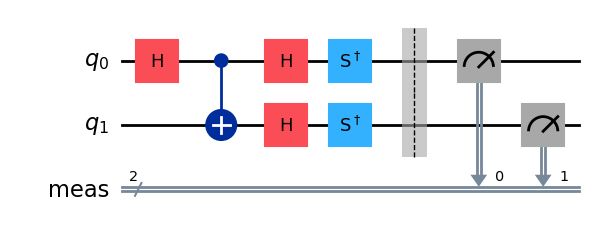

In [26]:
qc_y = qc.copy()
qc_y.remove_final_measurements()

# change in measurement basis to Y
qc_y.h([0,1])
qc_y.sdg([0,1])

# measure in Z basis
qc_y.measure_all()

qc_y.draw('mpl')

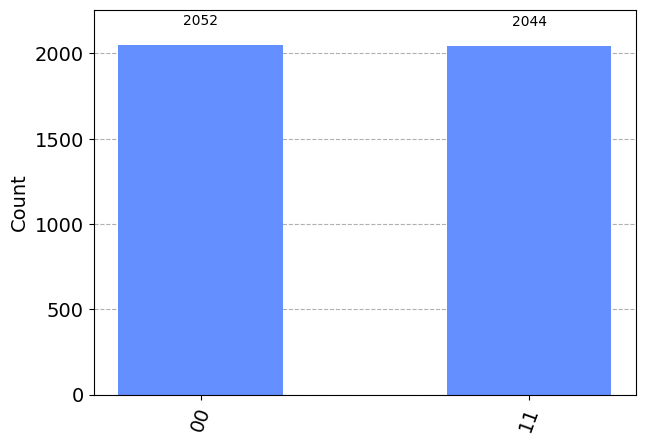

In [27]:
counts_y = sampler.run([qc_y]).result()[0].data.meas.get_counts()
plot_histogram(counts_y)

In [28]:
expval_yy = sampled_expectation_value(counts_y, observable_zz)
print(f'Expectation value of <YY> is {expval_yy}')

Expectation value of <YY> is 1.0


#### Finding the minimum number of circuits

Let us assume that you want to calculate the expectation values of multiple observables on the circuit: say 1. $\langle ZI \rangle$, 2. $\langle ZX \rangle$, 3. $\langle YX \rangle$, 4. $\langle IX \rangle$.

Note that for these four observables, the brute-force method will be to create four different circuits to measure these. But if two observables commute qubit-wise, then a single circuit is sufficient to calculate the expectation value of both the observables.

In this example, $[ZI, IX] = 0$, $[ZI, ZX] = 0$ and $[ZX, IX] = 0$. Therefore, it is possible to construct a single circuits to measure all three of these observables. Another circuit is required to measure $\langle YX \rangle$. Therefore, only two circuits are sufficient.

<b>Food for thought</b>: What should be the rotations for the measurement on each circuit so that we can measure $\langle ZI \rangle$, $\langle ZX \rangle$ and $\langle IX \rangle$ using a single circuit?

<b>All these intricate calculations on the minimum number of circuits needed, the rotation required for each qubit are taken care of by the Qiskit Runtime Primitive: Estimator</b>.

### Obtaining the expectation value: Introduction to Estimator

In [29]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=backend)

Using estimator allows you to also use different error suppression and mitigation methods to your problem without manually working on it. For example,

*estimator.options.dynamical_decoupling.enable = True*

*estimator.options.dynamical_decoupling.sequence_type = 'xpxm'*

*estimator.options.resilience.measure_mitigation=True*

*estimator.options.resilience.zne_mitigation=True*

As we saw that measurement in different basis requires different rotation gates to be appended before measurement, so estimator jobs do not accept circuits with measurements. We need to submit circuits without measurement; estimator will add them with proper rotation gates.

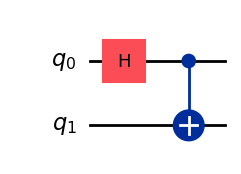

In [30]:
qc.remove_final_measurements()
qc.draw('mpl')

Let us consider all four observables we took in the previous discussion, and also $ZZ$.

In [31]:
observables = [
    SparsePauliOp('ZI'),
    SparsePauliOp('ZX'),
    SparsePauliOp('YX'),
    SparsePauliOp('IX'),
    SparsePauliOp('ZZ')
]

observables

[SparsePauliOp(['ZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['YX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZ'],
               coeffs=[1.+0.j])]

Estimator takes a tuple (circuit, observable) as its input. As with sampler, we can provide multiple tuples together as an array. For this example, we only have one circuit with a set of observables -- leading to an array with a single tuple. So we need to consider the 0-th element of result.

In [32]:
job = estimator.run([(qc, observables)])
result = job.result()[0]

In [33]:
expvals = result.data.evs
expvals

array([ 0.00341797, -0.00292969,  0.01708984, -0.00634766,  1.        ])

Note that these expectation values suffer from statistical/shot noise. In other words, we would get the ideal expectation values if we can take inifnite shots.

Now let us assume that the final value which we wanted to calculate was some linear combination of these expectation values. For example: $O = 0.1\langle ZI \rangle - 0.5\langle ZX \rangle + 0.3\langle YX \rangle + 0.2\langle IX \rangle - 0.4\langle ZZ \rangle$.

We already have the individual values, so we can easily calculate this linear combination.

In [48]:
combination = 0.1*expvals[0] - 0.5*expvals[1] + 0.3*expvals[2] + 0.2*expvals[3] - 0.4*expvals[4]
print(f'Value of the linear combination is {combination}')

Value of the linear combination is -0.3943359375


#### Using SparsePauliOp with proper coefficients

Instead of having an array of individual observables, and then calculating the combination manually, one can also set the whole thing as a single observable $O$ where each Pauli has a corresponding coefficient.

In [49]:
obs = SparsePauliOp(['ZI','ZX','YX','IX','ZZ'], coeffs=[0.1,-0.5,0.3,0.2,-0.4])
obs

SparsePauliOp(['ZI', 'ZX', 'YX', 'IX', 'ZZ'],
              coeffs=[ 0.1+0.j, -0.5+0.j,  0.3+0.j,  0.2+0.j, -0.4+0.j])

Note now that this is a single observable. If we compute with this observable, we won't obtain the expectation values for individual terms, rather will obtain the expectation value of $O = 0.1\langle ZI \rangle - 0.5\langle ZX \rangle + 0.3\langle YX \rangle + 0.2\langle IX \rangle - 0.4\langle ZZ \rangle$.

In [50]:
job = estimator.run([(qc, obs)])
result = job.result()[0]

In [51]:
expval_combined = result.data.evs

In [38]:
print(f'The expectation value of O is {expval_combined}')

The expectation value of O is -0.403857421875


### Running on fake hardware

Now we show an example of obtaining expectation value on noisy backend. Instead of running on real backend, we show on Fake Backend, which contains most of the properties (e.g., coupling map, noise profile) of real backend.

In [39]:
from qiskit_ibm_runtime.fake_provider import FakeKolkata

fake_backend = FakeKolkata()

We can visualize the properties of this backend.

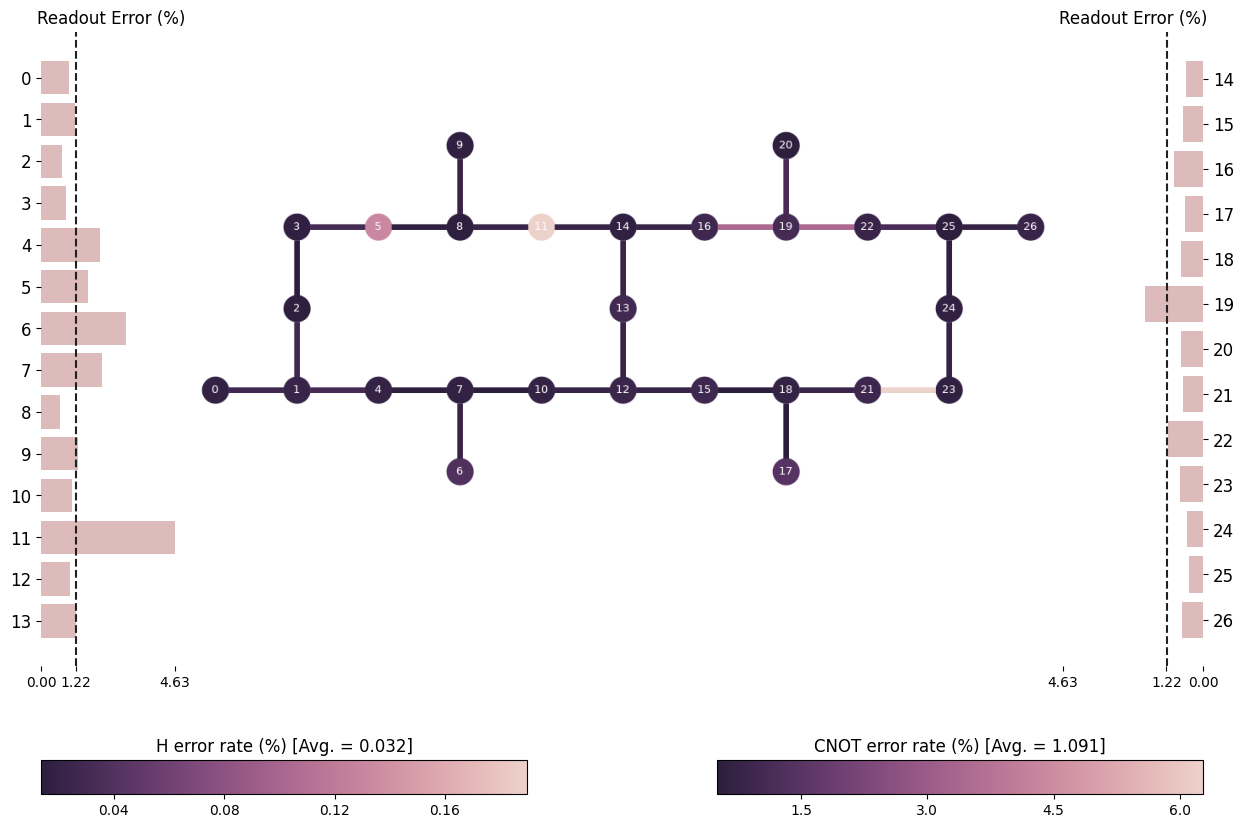

In [40]:
from qiskit.visualization import plot_error_map

plot_error_map(fake_backend, show_title=False)

In order to run a circuit on the real backend (or fake backend as in this example), it is necessary to transpile the circuit. Transpilation maps the circuit to the basis gates of the backend, and adds swap gates whenever necessary to make the circuit amenable to the coupling map.

In [41]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
isa_qc = pm.run(qc)

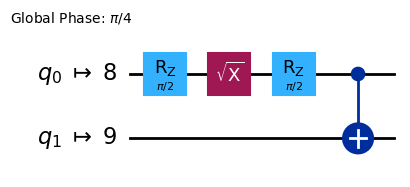

In [42]:
isa_qc.draw('mpl', idle_wires=False)

Note now that $q_0$ and $q_1$ has been placed on physical qubits 8 and 9 respectively. But an observable such as $ZZ$ implies $Z$ on qubits 0 and 1. This no longer conforms to the mapping of the transpiled circuit. So we need to ensure that our observable now has $Z$ acting on physical qubits 8 and 9, and $I$ elsewhere. We can easily apply this layout to the observable.

In [43]:
isa_obs = obs.apply_layout(isa_qc.layout)
isa_obs

SparsePauliOp(['IIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIZXIIIIIIII', 'IIIIIIIIIIIIIIIIIYXIIIIIIII', 'IIIIIIIIIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIIIIIIIIZZIIIIIIII'],
              coeffs=[ 0.1+0.j, -0.5+0.j,  0.3+0.j,  0.2+0.j, -0.4+0.j])

Note now each observable is of length 27 (same as the number of qubits in the backend), and the non-identity observables are placed on locations 8 and 9 to conform to the physical layout of the transpiled circuit.

Now we can use the *isa_qc* and *isa_obs* to obtain the same expectation value from fake backend.

In [44]:
noisy_job = estimator.run([(isa_qc, isa_obs)])
noisy_result = noisy_job.result()[0]

In [45]:
noisy_expval = noisy_result.data.evs

In [46]:
print(f'The expectation value of O from a noisy backend is {noisy_expval}')

The expectation value of O from a noisy backend is -0.39970703125


Here the circuit is small. Therefore, the effect of noise is minimal and not much apparent difference is observed between the noisy and ideal expectation value. However, for larger circuits, the difference will grow. There, using the suppression and mitigation methods from Estimator will be helpful to retrieve the ideal expectation value from the noisy one.

In [47]:
import qiskit_ibm_runtime
import qiskit

print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")
print(f"qiskit version {qiskit.version.get_version_info()}")

qiskit runtime version 0.22.0
qiskit version 1.0.2
